In [1]:
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt

# Import our custom modules
from generative_finance.models import (
    build_autoencoder, 
    build_generator, 
    build_discriminator
)
from generative_finance.training import TimeGANTrainer

/Users/sankalpyadav/Desktop/QuantProjects/GAN-Transformers-Synthetic-Data/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Configuration

In [2]:
# Select which stock to train on
TICKER = 'AAPL'

# Model Hyperparameters
SEQ_LEN = 24
FEATURE_DIM = 1 # We are using a univariate time series (Adj Close price)
LATENT_DIM = 48 # Dimensionality of the latent space
NUM_LAYERS = 2  # Number of GRU layers in the models

# Training Hyperparameters
EPOCHS = 500 # Total number of training epochs
BATCH_SIZE = 128
LEARNING_RATES = {
    'autoencoder': 0.001,
    'supervisor': 0.001,
    'gan': {
        'generator': 0.001,      # Keep generator's LR high
        'discriminator': 0.00001 # Decrease discriminator's LR further
    }
}

print("--- Configuration Loaded ---")
print(f"Target Ticker: {TICKER}")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Epochs: {EPOCHS}")

--- Configuration Loaded ---
Target Ticker: AAPL
Latent Dimension: 48
Epochs: 500


## 2. Load Pre-processed Data

In [3]:
try:
    data_path = f'data/processed/{TICKER}_data.npy'
    scaler_path = f'data/processed/{TICKER}_scaler.joblib'
    
    # Load the numpy array and the scaler
    data = np.load(data_path)
    scaler = joblib.load(scaler_path)
    
    print(f"\n--- Data Loaded Successfully ---")
    print(f"Data shape: {data.shape}")
    
except FileNotFoundError:
    print(f"Error: Data for ticker {TICKER} not found. Please run the data preparation notebook first.")
    exit()



--- Data Loaded Successfully ---
Data shape: (2614, 24, 1)


## 3. Build the TimeGAN Models

In [4]:
encoder, recovery = build_autoencoder(SEQ_LEN, LATENT_DIM, FEATURE_DIM)
generator = build_generator(SEQ_LEN, LATENT_DIM)
discriminator = build_discriminator(SEQ_LEN, LATENT_DIM)

models = {
    'encoder': encoder,
    'recovery': recovery,
    'generator': generator,
    'discriminator': discriminator
}

print("\n--- Models Built Successfully ---")
models['discriminator'].summary()



--- Models Built Successfully ---


/Users/sankalpyadav/Desktop/QuantProjects/GAN-Transformers-Synthetic-Data/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sankalpyadav/Desktop/QuantProjects/GAN-Transformers-Synthetic-Data/.venv/lib/python3.9/site-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 24, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 24, 48)         │        14,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 48)             │        14,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,273 (110.44 KB)

 Trainable params: 28,273 (110.44 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Initialize and Run the Trainer

In [5]:
trainer = TimeGANTrainer(
    models=models,
    latent_dim=LATENT_DIM,
    learning_rates=LEARNING_RATES
)

print("\n--- Starting Model Training ---")
# This will begin the epoch-by-epoch training process
trainer.train(
    data=data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    g_train_steps=5  # Increase this value
)

print("\n--- Training Complete ---")


--- Starting Model Training ---


2025-07-05 21:30:34.952991: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 0, E_loss: 0.1318, G_loss_S: 0.2039, G_loss_U: 0.4156, D_loss: 1.7639


2025-07-05 21:30:37.119197: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-05 21:30:41.441250: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-05 21:30:50.103642: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 10, E_loss: 0.0132, G_loss_S: 0.0323, G_loss_U: 0.5253, D_loss: 1.5474


2025-07-05 21:31:07.755521: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 20, E_loss: 0.0077, G_loss_S: 0.0365, G_loss_U: 0.7496, D_loss: 1.2798
Epoch: 30, E_loss: 0.0062, G_loss_S: 0.0309, G_loss_U: 0.9242, D_loss: 1.0553


2025-07-05 21:31:51.503050: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 40, E_loss: 0.0066, G_loss_S: 0.0332, G_loss_U: 1.0885, D_loss: 0.8601
Epoch: 50, E_loss: 0.0066, G_loss_S: 0.0356, G_loss_U: 1.1741, D_loss: 0.7765
Epoch: 60, E_loss: 0.0032, G_loss_S: 0.0357, G_loss_U: 1.3773, D_loss: 0.6529


2025-07-05 21:33:20.488532: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 70, E_loss: 0.0042, G_loss_S: 0.0372, G_loss_U: 1.6351, D_loss: 0.5252
Epoch: 80, E_loss: 0.0045, G_loss_S: 0.0322, G_loss_U: 1.9137, D_loss: 0.4184
Epoch: 90, E_loss: 0.0027, G_loss_S: 0.0350, G_loss_U: 1.9672, D_loss: 0.3611
Epoch: 100, E_loss: 0.0039, G_loss_S: 0.0351, G_loss_U: 2.4536, D_loss: 0.2315
Epoch: 110, E_loss: 0.0028, G_loss_S: 0.0333, G_loss_U: 2.5932, D_loss: 0.1641
Epoch: 120, E_loss: 0.0047, G_loss_S: 0.0336, G_loss_U: 3.2732, D_loss: 0.0999


2025-07-05 21:36:24.344262: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 130, E_loss: 0.0024, G_loss_S: 0.0336, G_loss_U: 3.4926, D_loss: 0.0719
Epoch: 140, E_loss: 0.0020, G_loss_S: 0.0323, G_loss_U: 4.4946, D_loss: 0.0409
Epoch: 150, E_loss: 0.0018, G_loss_S: 0.0324, G_loss_U: 4.4876, D_loss: 0.0324
Epoch: 160, E_loss: 0.0019, G_loss_S: 0.0312, G_loss_U: 4.5748, D_loss: 0.0237
Epoch: 170, E_loss: 0.0034, G_loss_S: 0.0337, G_loss_U: 4.9334, D_loss: 0.0189
Epoch: 180, E_loss: 0.0040, G_loss_S: 0.0331, G_loss_U: 5.2152, D_loss: 0.0153
Epoch: 190, E_loss: 0.0040, G_loss_S: 0.0338, G_loss_U: 5.3460, D_loss: 0.0135
Epoch: 200, E_loss: 0.0015, G_loss_S: 0.0317, G_loss_U: 5.7959, D_loss: 0.0096
Epoch: 210, E_loss: 0.0032, G_loss_S: 0.0302, G_loss_U: 5.7966, D_loss: 0.0081
Epoch: 220, E_loss: 0.0031, G_loss_S: 0.0319, G_loss_U: 6.0362, D_loss: 0.0073
Epoch: 230, E_loss: 0.0034, G_loss_S: 0.0323, G_loss_U: 6.4572, D_loss: 0.0057
Epoch: 240, E_loss: 0.0023, G_loss_S: 0.0306, G_loss_U: 6.1218, D_loss: 0.0063
Epoch: 250, E_loss: 0.0024, G_loss_S: 0.0311, G_loss

2025-07-05 21:42:26.677906: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 260, E_loss: 0.0031, G_loss_S: 0.0311, G_loss_U: 6.5306, D_loss: 0.0042
Epoch: 270, E_loss: 0.0013, G_loss_S: 0.0324, G_loss_U: 6.6203, D_loss: 0.0036
Epoch: 280, E_loss: 0.0013, G_loss_S: 0.0301, G_loss_U: 6.8090, D_loss: 0.0029
Epoch: 290, E_loss: 0.0019, G_loss_S: 0.0346, G_loss_U: 6.5714, D_loss: 0.0035
Epoch: 300, E_loss: 0.0027, G_loss_S: 0.0314, G_loss_U: 6.8983, D_loss: 0.0026
Epoch: 310, E_loss: 0.0033, G_loss_S: 0.0298, G_loss_U: 6.8066, D_loss: 0.0024
Epoch: 320, E_loss: 0.0030, G_loss_S: 0.0319, G_loss_U: 6.8982, D_loss: 0.0023
Epoch: 330, E_loss: 0.0022, G_loss_S: 0.0274, G_loss_U: 7.1602, D_loss: 0.0017
Epoch: 340, E_loss: 0.0021, G_loss_S: 0.0320, G_loss_U: 7.2808, D_loss: 0.0017
Epoch: 350, E_loss: 0.0011, G_loss_S: 0.0301, G_loss_U: 7.4092, D_loss: 0.0014
Epoch: 360, E_loss: 0.0021, G_loss_S: 0.0277, G_loss_U: 7.4930, D_loss: 0.0013
Epoch: 370, E_loss: 0.0011, G_loss_S: 0.0284, G_loss_U: 7.4537, D_loss: 0.0012
Epoch: 380, E_loss: 0.0012, G_loss_S: 0.0279, G_loss


## 5. Generate Synthetic Data (Post-Training)

In [6]:
print("\n--- Starting Synthetic Data Generation ---")

# Define the number of synthetic samples to generate
num_samples_to_generate = 500

# 1. Generate random noise sequences
random_noise = tf.random.normal(shape=(num_samples_to_generate, SEQ_LEN, LATENT_DIM))

# 2. Use the generator to create synthetic sequences in the latent space
generated_data_latent = models['generator'].predict(random_noise)
print(f"Shape of generated latent data: {generated_data_latent.shape}")

# 3. Use the recovery model to convert from latent space to real (scaled) space
# This is the crucial missing step.
generated_data_scaled = models['recovery'].predict(generated_data_latent)
print(f"Shape of recovered (scaled) data: {generated_data_scaled.shape}")

# 4. Reshape the data for the scaler
# The scaler expects a 2D array: (total_timesteps, features)
generated_data_reshaped = generated_data_scaled.reshape(-1, FEATURE_DIM)

# 5. Inverse transform the data to get the real price scale
synthetic_data = scaler.inverse_transform(generated_data_reshaped)

# 6. Reshape the final data back into sequences
synthetic_data = synthetic_data.reshape(num_samples_to_generate, SEQ_LEN, FEATURE_DIM)

print("\n--- Synthetic Data Generation Complete ---")
print(f"Final shape of synthetic data: {synthetic_data.shape}")


--- Starting Synthetic Data Generation ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Shape of generated latent data: (500, 24, 48)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Shape of recovered (scaled) data: (500, 24, 1)

--- Synthetic Data Generation Complete ---
Final shape of synthetic data: (500, 24, 1)


## 6. Plots

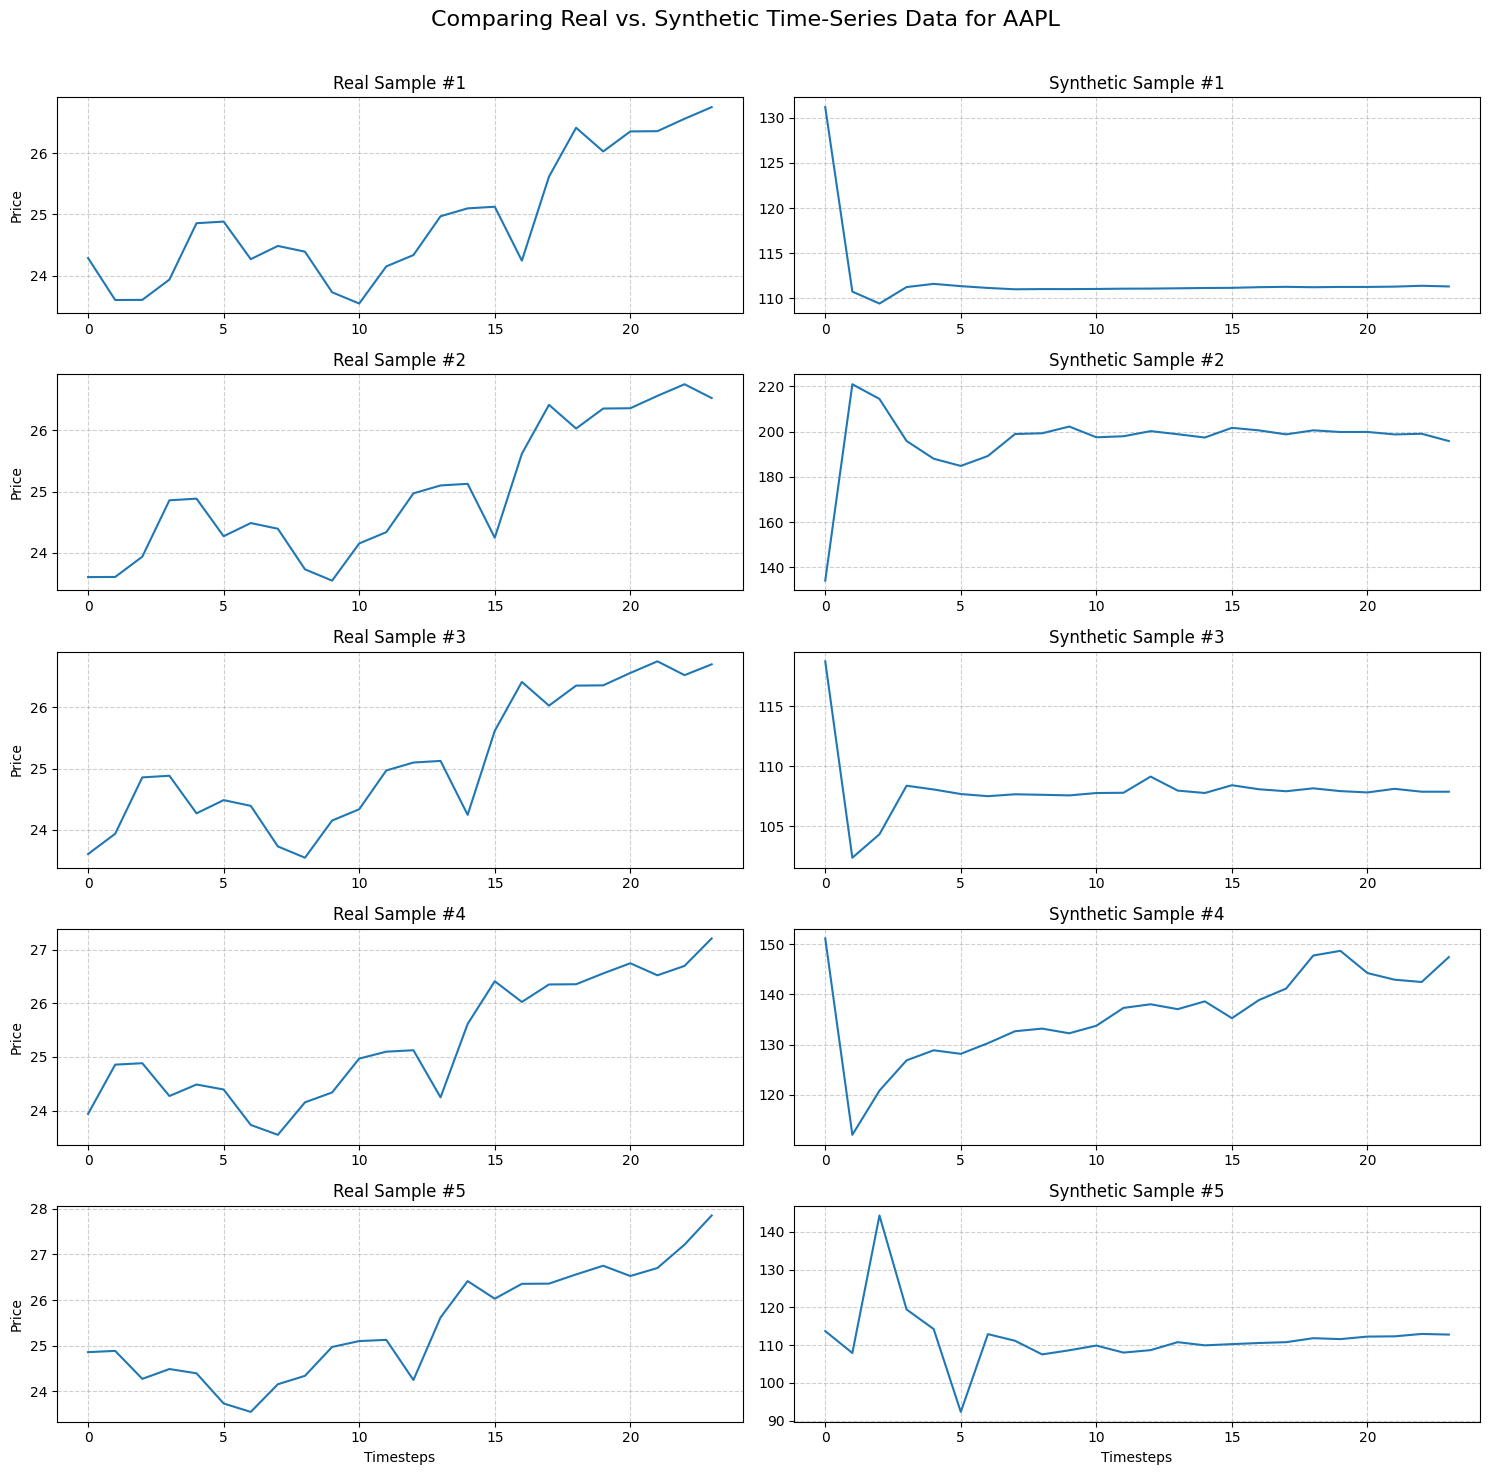

In [7]:
# -- 1. Configuration --
# Number of sample sequences to plot
num_to_plot = 5

# -- 2. Select Real and Synthetic Samples --
# Select the first few synthetic samples
synthetic_samples = synthetic_data[:num_to_plot]

# Select the first few real samples from the original pre-processed data
real_samples_scaled = data[:num_to_plot]

# -- 3. Inverse Transform the Real Samples to Original Price Scale --
# Reshape for the scaler
real_samples_reshaped = real_samples_scaled.reshape(-1, FEATURE_DIM)

# Inverse transform
real_samples_unscaled = scaler.inverse_transform(real_samples_reshaped)

# Reshape back to sequences
real_samples = real_samples_unscaled.reshape(num_to_plot, SEQ_LEN, FEATURE_DIM)


# -- 4. Create the Plots --
fig, axes = plt.subplots(nrows=num_to_plot, ncols=2, figsize=(15, num_to_plot * 3))
fig.suptitle(f'Comparing Real vs. Synthetic Time-Series Data for {TICKER}', fontsize=16)

for i in range(num_to_plot):
    # Plot Real Data
    axes[i, 0].plot(real_samples[i])
    axes[i, 0].set_title(f'Real Sample #{i + 1}')
    axes[i, 0].set_ylabel('Price')
    axes[i, 0].grid(True, linestyle='--', alpha=0.6)
    
    # Plot Synthetic Data
    axes[i, 1].plot(synthetic_samples[i])
    axes[i, 1].set_title(f'Synthetic Sample #{i + 1}')
    axes[i, 1].grid(True, linestyle='--', alpha=0.6)

# Add x-axis labels to the last row only
axes[-1, 0].set_xlabel('Timesteps')
axes[-1, 1].set_xlabel('Timesteps')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()